<a target="_blank" href="https://colab.research.google.com/github/skojaku/adv-net-sci/blob/main/notebooks/exercise-m02-small-world.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Computing the Shortest Paths and Connected Components

Let's use `igraph` to compute the shortest paths and connected components. We will then use `scipy` to compute them.

In [1]:
# If you are using Google Colab, uncomment the following line to install igraph
# !pip install python-igraph

## igraph

### Create a graph

Let us create a graph of 4 nodes and 4 edges. Our edge list is given by

In [2]:
edge_list = [(0, 1), (1, 2), (0, 2), (0, 3)]

`igraph` has an object `Graph` that stores a graph and provides methods to manipulate and analyze the graph. To create a graph from an edge list, we can use the `add_edges` method.

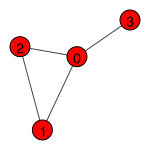

In [3]:
import igraph

g = igraph.Graph() # Create an empty graph
g.add_vertices(4) # Add 4 vertices
g.add_edges(edge_list) # Add edges to the graph

# Plot the graph
igraph.plot(g, bbox=(150, 150), vertex_label=list(range(4)))

### Shortest Paths

Let's compute the paths between nodes 2 and 3.

In [4]:
g.get_all_simple_paths(2, to=3)

[[2, 0, 3], [2, 1, 0, 3]]

This method enumerates all possible simple paths between two nodes. This is OK for small networks but quickly becomes impractical for larger networks, as the number of paths increases exponentially with the size of the network.

Often, we are interested in the shortest path, which is the path with the smallest number of edges. The shortest path can be computed by using the `get_shortest_paths` method.

In [5]:
g.get_shortest_paths(2, to=3)

[[2, 0, 3]]

Note that there can be multiple shortest paths between two nodes. If we are interested in the "length" instead of the path itself, there is a more efficient function `distances`.

In [6]:
g.distances(2, 3)

[[2]]

### Connected Components

In the simple network above, we can see that for every pair of nodes, we can find a path connecting them. This is the definition of a connected graph. We can check this property for a given graph:

In [7]:
components = g.connected_components()

The `components` is a special object called [VertexClustering](https://python.igraph.org/en/0.11.6/api/igraph.VertexClustering.html) in `igraph`.
It has the following useful functions and attributes:

In [8]:
print("membership: ", components.membership)  # the IDs of the component each node belongs to.
print("sizes: ", list(components.sizes()))  # the number of nodes in each component.
print("giant: ", components.giant())  # a subgraph of the largest connected component.

membership:  [0, 0, 0, 0]
sizes:  [4]
giant:  IGRAPH U--- 4 4 --
+ edges:
0--1 1--2 0--2 0--3


#### Exercise 01 🏋️‍♀️💪🧠

1. Now, let us add two nodes that are not connected to the existing graph, and call `connected_components` again. 🔗➕

2. Call `get_shortest_paths` between the two new nodes in different connected components. 🛣️🔍

3. Get the largest connected component. 🌐🏆

### Directed networks
Let's extend these ideas about paths and connected components to directed graphs.

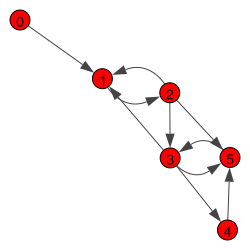

In [9]:
edge_list =[(0, 1), (1, 2), (2, 1), (2, 3), (2, 5), (3, 1), (3, 4), (3, 5), (4, 5), (5, 3)]
g = igraph.Graph(directed=True)
g.add_vertices(6)
g.add_edges(edge_list)
igraph.plot(g, bbox=(250, 250), vertex_label=list(range(6)))

In directed graphs, edges and paths can be one-way. For instance, in our graph, you can go from node 0 to node 3, but not from 3 to 0.

In [10]:
print("From 0 to 3", g.get_all_simple_paths(0, to=3))
print("From 3 to 0", g.get_all_simple_paths(3, to=0))

From 0 to 3 [[0, 1, 2, 3], [0, 1, 2, 5, 3]]
From 3 to 0 []


The shortest path from 4 to 1 must take a longer route due to edge directions.

In [11]:
g.get_shortest_paths(4, 1)

[[4, 5, 3, 1]]

Directed networks have two kinds of connected components.

- **Strongly connected components:** Strongly connected means that there exists a direct path between every pair of nodes, i.e., that from any node to any other nodes while respecting the edge directionality.
- **Weakly connected components:** Weakly connected means that there exists a path between every pair of nodes when ignoring the edge directionality.

In [12]:
print(list(g.connected_components(mode="strong")))
print(list(g.connected_components(mode="weak")))

[[0], [1, 2, 3, 4, 5]]
[[0, 1, 2, 3, 4, 5]]


## Scipy

We can create a graph, compute the shortest paths, and connected components using `scipy`.

### Create a graph


With scipy, we represent a network by an adjacency matrix using something called a *Compressed Sparse Row (CSR) matrix*. CSR matrices are efficient format for storing and manipulating *sparse* matrices. Why *sparse* is highlighed here? Because in many networks, the adjacency matrix is sparse, i.e., most of the entries are zero. For example, here is the adjacency matrix of a real-world network:

![](https://www.researchgate.net/publication/263506932/figure/fig1/AS:392539896074252@1470600212952/Scale-free-Network-left-its-adjacency-matrix-upper-right-and-degree-distribution.png)

Most of the entries in this adjacency matrix are white, and white means that the value of the entry is zero. And the adjacency matrix looks very white! This is pretty common in real-world networks. We call these matrices "sparse" because they are mostly empty. And CSR matrices are a way to store these sparse matrices efficiently. Don't worry too much about the technical details for now. If you're curious to learn more, you can check out the [Appendix](appendix.md).

The great thing is, `scipy` (especially the `scipy.sparse` module) provides efficient tools for working with these sparse matrices. This comes in really handy when we're working with large networks.

Let create a graph using scipy.

In [13]:
from scipy import sparse # We will use sparse module in scipy

edge_list = [(0, 1), (1, 2), (0, 2), (0, 3)]

src = [src for src, dst in edge_list]
trg = [dst for src, dst in edge_list]
weight = [1 for src, dst in edge_list]

A = sparse.csr_matrix((weight, (src, trg)))
A = A + A.T # Make the adjacency matrix symmetric
A

ValueError: inconsistent shapes

Let's break down the code.
- `src` and `trg` are the source and target nodes of the edges.
- `weight` is the weight of the edges.
- `sparse.csr_matrix((weight, (src, trg)))` creates a sparse matrix, filling `weight` into the positions specified by `(src, trg)`.
- `A.T` is the transpose of `A` and `A + A.T` makes the adjacency matrix symmetric.

The CSR matrix does not print nicely. But you can see it by converting to a numpy array and printing it.

In [ ]:
A.toarray()

## Shortest Paths

The `sparse` module has a submodule `csgraph` that provides APIs for network analysis.

For example, `csgraph.shortest_path` computes the shortest path length from a specific node to all other nodes.

In [ ]:
from scipy.sparse import csgraph

# `indices` is the node to compute the shortest path from.
D = csgraph.shortest_path(A, indices=2, directed=False)
D

**Advanced:** If you want to get the actual paths (i.e., list of nodes in the path), you can pass `return_predecessors=True` to `csgraph.shortest_path`.

In [ ]:
D, predecessors = csgraph.shortest_path(A, indices=2, directed=False, return_predecessors=True)

## Connected Components

Connected components can be computed by `csgraph.connected_components`.

In [ ]:
n_components, labels = csgraph.connected_components(A, directed=False, return_labels=True)

print("Number of connected components:", n_components)
print("Labels:", labels)

- `n_components` is the number of connected components.
- `labels` is an array of length `n_nodes` where each element is the ID of the connected component the node belongs to.


## Exercise 02 🏋️‍♀️💪🧠

Let's compute the average path length of a network from pre-existing data and check if how long on average it takes to go from any node to any other node.

1. Select a network of your choice from [Netzschleuder](https://networks.skewed.de/). For convenience, choose a network of nodes less than 5000.
2. Download the csv version of the data by clicking something like "3KiB" under `csv` column.
3. Unzip the file and find "edges.csv", open it with a text editor to familiarize yourself with the format.
4. Load the data using `pandas`.
5. Get the source and target nodes from the data to create an edge list.
6. Construct a graph from the edge list, either using `igraph` or `scipy`.
7. Compute the average path length

**Hint:** Finding all shortest paths is a qubic time operation with respect to the number of nodes, or simply put, it takes a long time to compute. So compute the "estimate" by sampling many pairs of nodes uniformly at random and computing the average path length.